In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from src.visualize import LossVisualizer

from src.models.mlp import MLP
from src.models.conv import ConvNet

from src.utils import init_dataloader
from src.train import train
from src.valid import valid

from src.visualize import calc_grid_loss
from src.visualize import LossVisualizer
from src.calc_delta import DeltaCalculator

import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision import datasets

import torch
import torch.nn as nn


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/jovyan/shares/SR004.nfs2/nkiselev/mv_exps/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


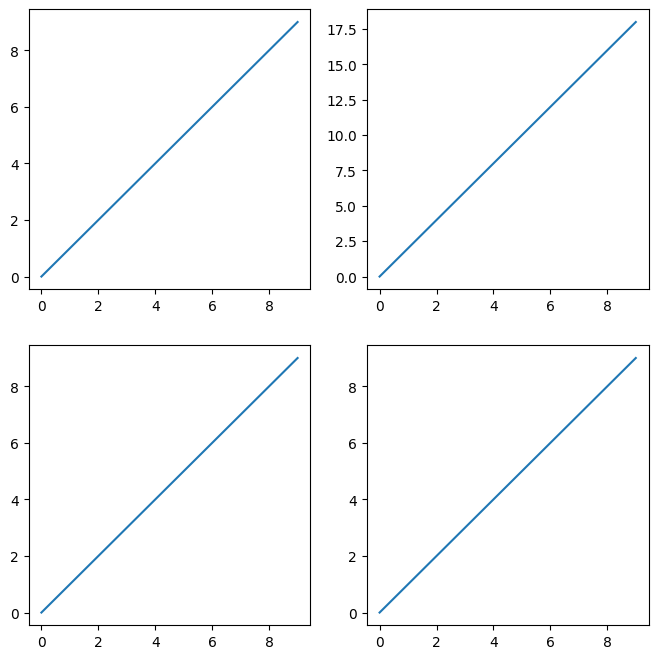

In [26]:
fig, axs = plt.subplots(ncols = 2, nrows=2, figsize = (8, 8))
axs[0][0].plot(np.arange(10), np.arange(10))
axs[0][1].plot(np.arange(10), np.arange(20, step = 2))
axs[1][0].plot(np.arange(10))
axs[1][1].plot(np.arange(10))
plt.savefig('foo.png')

In [2]:
import json
import argparse
from omegaconf import OmegaConf

In [3]:
config_path = 'configs/layers_num/cifar10.yml'
config = OmegaConf.load(config_path)

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(config['mean'], config['std'])])

loader = init_dataloader(
    dataset_name=config['dataset_name'],
    transform=transform,
    batch_size=64,
    dataset_load_path='data/',
    train_mode=True,
)

100%|██████████| 170M/170M [01:31<00:00, 1.86MB/s] 


Extracting data/CIFAR10_dataset/cifar-10-python.tar.gz to data/CIFAR10_dataset


In [6]:
config

{'dataset_name': 'CIFAR10', 'mean': [0.4914, 0.4822, 0.4465], 'std': [0.2023, 0.1994, 0.201], 'train_batch_size': 64, 'learning_rate': 0.0003, 'num_epochs': 20, 'input_size': [32, 32], 'input_channels': 3, 'channels': 32, 'layers_num_range': [2, 4, 6, 8, 10], 'kernel_size': 3, 'classes': 10}

In [7]:
layers_num_to_deltas = {}
for layers_num in config['layers_num_range']:
    channels_list = [config['input_channels']] + [config['channels'] for _ in range(layers_num)]
    model = ConvNet(channels_list, tuple(config['input_size']), config['classes']).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = config['learning_rate'])
    criterion = nn.CrossEntropyLoss()

    model, _ = train(
        model,
        optimizer,
        criterion,
        loader,
        num_epochs=config['num_epochs'],
        device=DEVICE
    )
    delta_calc = DeltaCalculator(model, loader, criterion)

    deltas = delta_calc.calc_deltas(mode = 'random-subspace-proj',
                       mode_params = {'estim_func':'abs', 'sigma':3, 'dim':2},
                       num_samples=32)

    layers_num_to_deltas[layers_num] = deltas

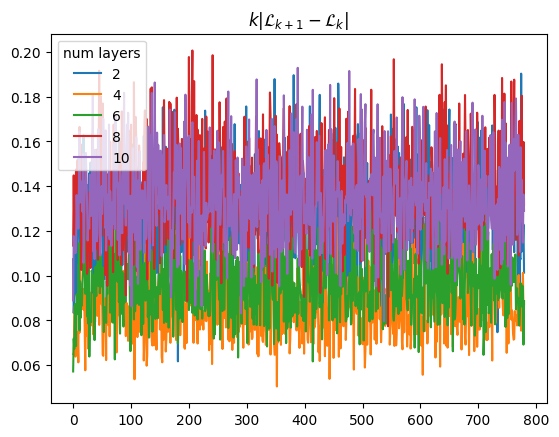

In [8]:
mean_deltas = {i:np.mean(layers_num_to_deltas[i][:-1]*np.arange(1, len(layers_num_to_deltas[i]))) for i in layers_num_to_deltas.keys()}
for i in layers_num_to_deltas.keys():
    plt.plot(layers_num_to_deltas[i][:-1]*np.arange(1, len(layers_num_to_deltas[i])), label = f'{i}')
plt.legend(title = 'num layers')
plt.title('$k|\mathcal{L}_{k+1} - \mathcal{L}_k|$')
plt.show()

In [17]:
layers_num_to_deltas = {}
for layers_num in config['layers_num_range']:
    sizes_list = [32*32*3] + [128]*layers_num + [config['classes']]
    model = MLP(sizes_list).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = config['learning_rate'])
    criterion = nn.CrossEntropyLoss()

    model, _ = train(
        model,
        optimizer,
        criterion,
        loader,
        num_epochs=config['num_epochs'],
        device=DEVICE
    )
    delta_calc = DeltaCalculator(model, loader, criterion)

    deltas = delta_calc.calc_deltas(mode = 'random-subspace-proj',
                       mode_params = {'estim_func':'abs', 'sigma':3, 'dim':2},
                       num_samples=32)

    layers_num_to_deltas[layers_num] = deltas

Train loop:   0%|          | 0/20 [00:00<?, ?it/s]

Train loop:   0%|          | 0/20 [00:00<?, ?it/s]

Train loop:   0%|          | 0/20 [00:00<?, ?it/s]

Train loop:   0%|          | 0/20 [00:00<?, ?it/s]

Train loop:   0%|          | 0/20 [00:00<?, ?it/s]

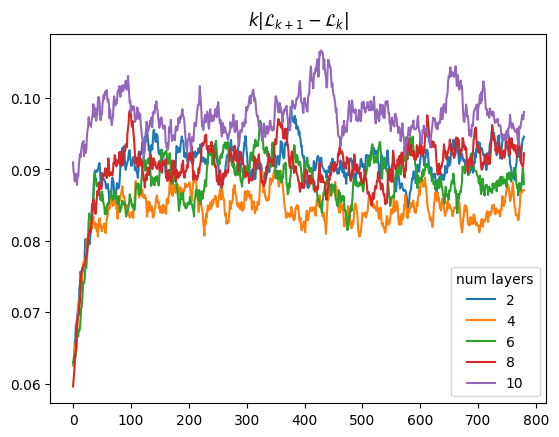

In [44]:
#mean_deltas = {i:np.mean(layers_num_to_deltas[i][:-1]*np.arange(1, len(layers_num_to_deltas[i]))) for i in layers_num_to_deltas.keys()}
for i in layers_num_to_deltas.keys():
    plt.plot(ewma(layers_num_to_deltas[i][:-1]*np.arange(1, len(layers_num_to_deltas[i])), 30), label = f'{i}')
plt.legend(title = 'num layers')
plt.title('$k|\mathcal{L}_{k+1} - \mathcal{L}_k|$')
plt.show()

In [49]:
layer_size_to_deltas = {}
for layer_size in [32, 64, 128, 256]:
    sizes_list = [32*32*3] + [layer_size]*6 + [config['classes']]
    model = MLP(sizes_list).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = config['learning_rate'])
    criterion = nn.CrossEntropyLoss()

    model, _ = train(
        model,
        optimizer,
        criterion,
        loader,
        num_epochs=config['num_epochs'],
        device=DEVICE
    )
    delta_calc = DeltaCalculator(model, loader, criterion)

    deltas = delta_calc.calc_deltas(mode = 'random-subspace-proj',
                       mode_params = {'estim_func':'abs', 'sigma':3, 'dim':2},
                       num_samples=32)

    layer_size_to_deltas[layer_size] = deltas

Train loop:   0%|          | 0/20 [00:00<?, ?it/s]

Train loop:   0%|          | 0/20 [00:00<?, ?it/s]

Train loop:   0%|          | 0/20 [00:00<?, ?it/s]

Train loop:   0%|          | 0/20 [00:00<?, ?it/s]

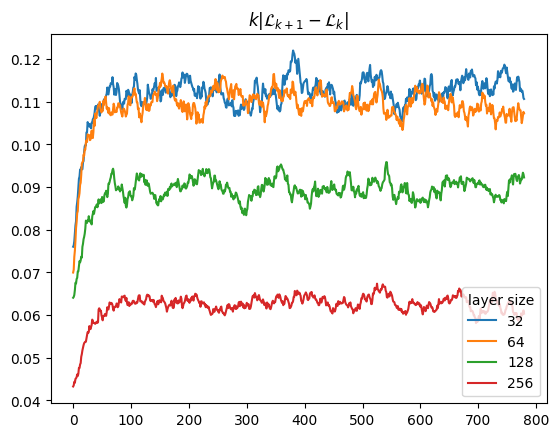

In [50]:
#mean_deltas = {i:np.mean(layers_num_to_deltas[i][:-1]*np.arange(1, len(layers_num_to_deltas[i]))) for i in layers_num_to_deltas.keys()}
for i in [32, 64, 128, 256]:
    plt.plot(ewma(layer_size_to_deltas[i][:-1]*np.arange(1, len(layer_size_to_deltas[i])), 30), label = f'{i}')
plt.legend(title = 'layer size')
plt.title('$k|\mathcal{L}_{k+1} - \mathcal{L}_k|$')
plt.show()